In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sb
import matplotlib.ticker as ticker
import scipy.stats as sp
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from xgboost import plot_importance, plot_tree

%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

In [3]:
#codebook = pd.read_csv("owid-covid-codebook.csv")
owid_df = pd.read_csv("owid-covid-data.csv")
owid_df = owid_df.sort_values('date', ascending=True) #very important since we can easily misterpret if the dates are not sorted
owid_df['date'] = pd.to_datetime(owid_df['date'], format = '%Y-%m-%d')

## We first find a baseline on what's happened globally so far

In [4]:
all_continents = owid_df['continent'].unique()
all_continents

array(['South America', 'North America', 'Asia', 'Europe', nan, 'Oceania',
       'Africa'], dtype=object)

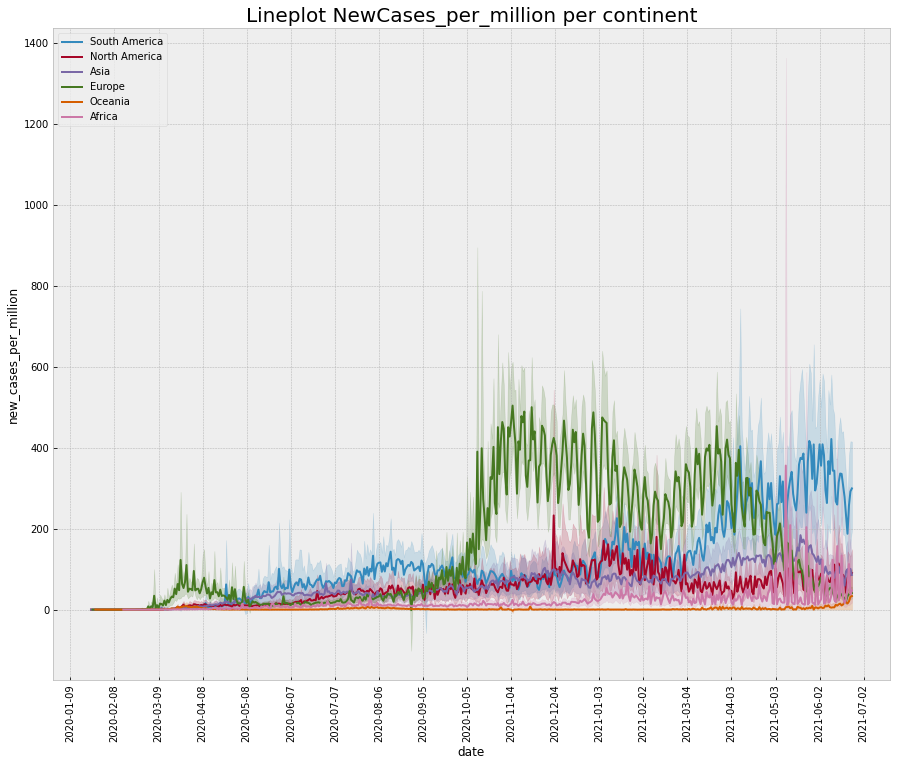

In [5]:
plt.style.use('bmh')

fig = plt.subplots(figsize=(15, 12))

scatter_ax = sns.lineplot(data=owid_df, x='date', y='new_cases_per_million', hue='continent')
scatter_ax.set_title('Lineplot NewCases_per_million per continent', size=20)
scatter_ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

plt.legend(loc='upper left')
plt.setp(scatter_ax.get_xticklabels(), rotation=90)
print()

- We see that the new cases per million is still near its peak in South America, however it is surprising to see that Asian countries (usually reported with high number of daily cases) have lower cases per million.
- This is mostly due to the fact that the population density is high in asian countries

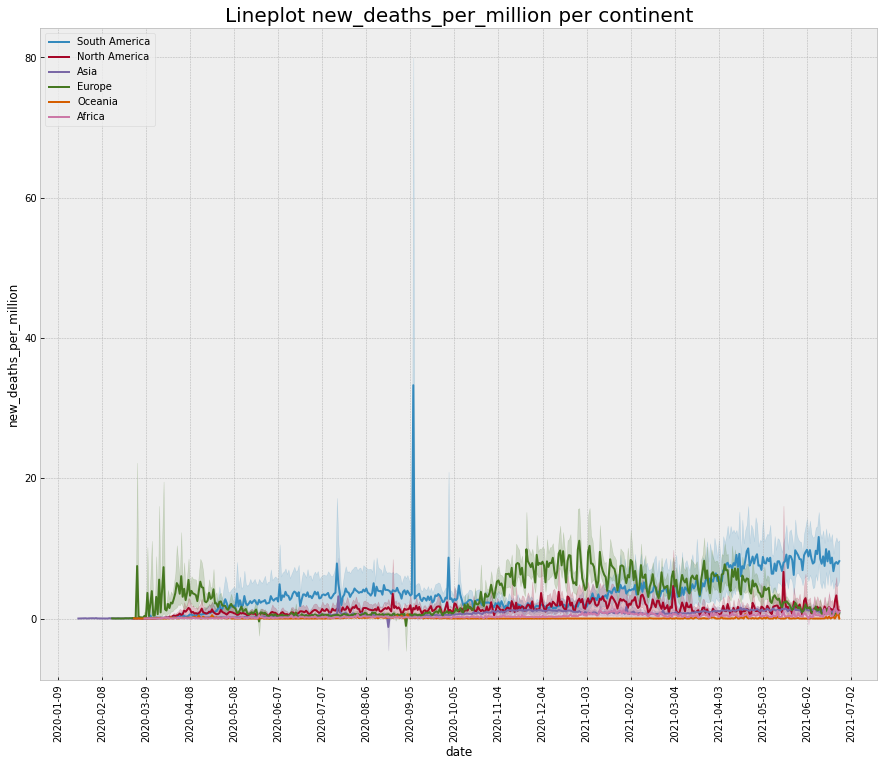

In [6]:
plt.style.use('bmh')

fig = plt.subplots(figsize=(15, 12))

scatter_ax = sns.lineplot(data=owid_df, x='date', y='new_deaths_per_million', hue='continent')
scatter_ax.set_title('Lineplot new_deaths_per_million per continent', size=20)
scatter_ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

plt.legend(loc='upper left')
plt.setp(scatter_ax.get_xticklabels(), rotation=90)
print()

## Our Generalised Projection Model

We focus on the following:
- X = 
        stringency score, 
        vaccination ratio = Total people_vaccinated(atleast 1 dose) / Total population in 2020,  
        reproduction_rate,
        positive_rate
        
- Y = Number of new deaths per million

Since we do not have any country specific input parameters, our model can be used as a global baseline

### Note:
- We do not add a decay to Reproduction rate over a period of time. However, the reproduction rate reduces after the pandemic ends and we expect the model to infer this reproduction decay rate on its own
- We do not add a growth parameter for vaccination ratio (assuming there is enough supply of vaccine for the total population) as we expect the model to infer this vaccination ratio to increase on its own

We believe this should help out any country to crunch the parameters to get an estimate of what might happen on Nth-day when they have the following:
> stringency score : This is the current stringency score >~~We use a mean over the last 15 days because few policies have delayed effects whereas few policies have faster effect on the new cases/deaths per million~~

> vaccination ratio : 
    Since the population density is very different in many countries, having a ratio of the number of people who have been vaccinated and the total population before the pandemic, keeps our data proportional across all the countries

> positive_rate : The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)

> current reproduction rate : if R<1 then the pandemic has subsided towards an endemic, however if R>1 then the pandemic still prevails. I am guessing this should have an impact because we measure the new deaths after N-days
* COVID-19 is estimated to have a much higher R0∼ from 1.4 to 6.5. In fact, there is no unique number since transmission is heavily dependent upon population density and structure as well as the biological characteristics.

Prediction Variable :
> Number of deaths per million: This is our target variable

#### Approach for projection model:
> Once we create the model to predict the number of deaths on the current day, we will synthetically project our features for N-days in future to predict the number of deaths on N-days in future

# Preparing the dataset

In [7]:
# since we need the vaccination ratio, based on the country population we calculate as follows:
# vaccination ratio = (people vaccinated)/(population in 2020) 
# This way the ratio remains consistent before we proceed with further data processing
vaccination_ratio = owid_df['people_vaccinated']/owid_df['population']
owid_df.insert(loc=10,column='vaccination_ratio',value = list(vaccination_ratio))

In [8]:
mean_owid_df = owid_df.groupby(['date']).mean()
# we need only the following columns
#X
# date: this is already our index
# stringency_index : score between 0-100
# population  (this is the population in 2020)
# people_vaccinated
# positive_rate
# reproduction_rate (current R rate)
# 

#Y : new_deaths_per_million

In [9]:
mean_owid_df.drop(mean_owid_df.columns.difference(['stringency_index',
                                                   'vaccination_ratio',
                                                   'positive_rate',
                                                   'reproduction_rate',
                                                  'new_deaths_per_million']), 1, inplace=True)

In [10]:
mean_owid_df

,vaccination_ratio,new_deaths_per_million,reproduction_rate,positive_rate,stringency_index
date,,,,,
2020-01-01,NaN,NaN,NaN,NaN,0.000000
2020-01-02,NaN,NaN,NaN,NaN,0.000000
2020-01-03,NaN,NaN,NaN,NaN,0.000000
2020-01-04,NaN,NaN,NaN,NaN,0.000000
2020-01-05,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...
2021-06-21,0.317570,1.626466,0.917065,0.069010,53.681970
2021-06-22,0.310063,1.730358,0.919239,0.070266,49.714615
2021-06-23,0.299364,1.337974,NaN,0.071345,39.074000


We can drop the last three rows, dates from 23-06-2021 because it does not contain much data. So let's proceed using data until 22-06-2021

In [11]:
mean_owid_df = mean_owid_df[:-3]

## Solving Missing Values in the dataset
We see that there are many rows with NaN values. 
These are the things we do to handle them for each column:
<br>
- a) new_deaths_per_million: Until 22-01-2020, there were no new deaths reported so we can make all the values as 0 until this date
<br>
<br>
- b) reproduction rate: Since we see a trend where the reproduction rate is reducing from 3.1 from 23-01-2020, we can find the mean difference between the reproduction rate and linearly interpolate it backwards. However a good statistical approach can also be to use regression, by using the dates in descending order
<br>

- c) vaccination_ratio: Since the vaccination ratio is 0 until the first person is vaccinated, we can go ahead and make it 0 for all rows before that day.

- d) Positive_rate : We can go ahead and make the positive_rate zero until 06-01-2020 because no specific tests were developed to identify Covid until then

<br>
- 

### a) Handling - new_deaths_per_million :
- make everything 0 before 22-01-2020

In [12]:
mean_owid_df['new_deaths_per_million'] = mean_owid_df['new_deaths_per_million'].fillna(0)

c:\users\bhara\anaconda3\envs\aimed\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
mean_owid_df

,vaccination_ratio,new_deaths_per_million,reproduction_rate,positive_rate,stringency_index
date,,,,,
2020-01-01,NaN,0.000000,NaN,NaN,0.000000
2020-01-02,NaN,0.000000,NaN,NaN,0.000000
2020-01-03,NaN,0.000000,NaN,NaN,0.000000
2020-01-04,NaN,0.000000,NaN,NaN,0.000000
2020-01-05,NaN,0.000000,NaN,NaN,0.000000
...,...,...,...,...,...
2021-06-18,0.299705,1.289876,0.909511,0.070330,52.703925
2021-06-19,0.284928,1.184026,0.911413,0.071255,52.440109
2021-06-20,0.284624,1.027741,0.913696,0.065265,53.084186


### b) Handling - reproduction rate:
- we start by arranging the dataframe in descending order of time 
- we need a new column called days_behind_from current_day as a reference to predict the reproduction rate given for N-days in the past
- organise and split the datapoints to train

> 1) We try to fit a simple regression model which captures the trend of reproduction rate

> 2) We reorganise this linear regression for a smaller timeperiod to fit the reproduction rate and we see significant performance increase

##### Linear regression

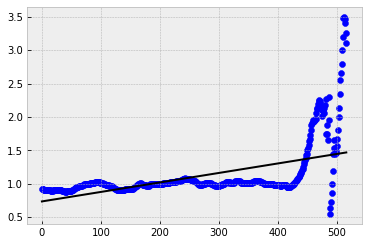

Model Score: 0.32028641382865386


In [14]:
descending_time_mean_owid_df = mean_owid_df.sort_index(ascending=False)

# we need a new column called days_behind_from current_day as a reference to predict 
# the reproduction rate given for N-days in the past
descending_time_mean_owid_df['days_behind_from_now'] = (descending_time_mean_owid_df.index[0] - descending_time_mean_owid_df.index).days
descending_time_mean_owid_df = descending_time_mean_owid_df[descending_time_mean_owid_df['reproduction_rate'].notna()]

# the data points required to predict the reproduction rate
reproduction_rate_y = list(descending_time_mean_owid_df.reproduction_rate)
reproduction_rate_x = descending_time_mean_owid_df['days_behind_from_now'].values.reshape(-1, 1)

# split the datapoints to test and train
X_train, X_test, y_train, y_test = train_test_split(reproduction_rate_x, reproduction_rate_y, test_size=0.33, random_state=42)

# fit a linear regression model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# check to see the models prediction over the entire dataset
plt.scatter(reproduction_rate_x, reproduction_rate_y,color='b')
plt.plot(reproduction_rate_x, model.predict(reproduction_rate_x),color='k')
plt.show()
print("Model Score:",model.score(X_test,y_test))

 When the regression model is fit over the entire dataset we see a big deviation from the model prediction from the period ~450 days back from today. As this big deviation will impact our dataset in a negative manner we find alternative methods

We Notice that the reproduction rate is relatively linear from ~500 days back from 23-06-2021. So we will train the model only for this period and get an approx. prediction until 01-01-2020 

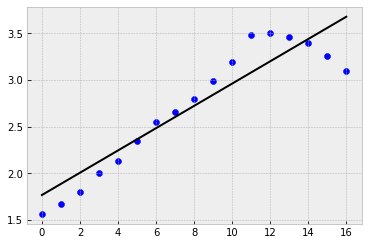

Model Score: 0.9099349772494968


In [15]:
descending_time_mean_owid_df = mean_owid_df.sort_index(ascending=False)
descending_time_mean_owid_df = descending_time_mean_owid_df[500:]

# we need a new column called days_behind_from current_day as a reference to predict the reproduction rate given for N-days in the past
descending_time_mean_owid_df['days_behind_from_now'] = (descending_time_mean_owid_df.index[0] - descending_time_mean_owid_df.index).days
descending_time_mean_owid_df = descending_time_mean_owid_df[descending_time_mean_owid_df['reproduction_rate'].notna()]

# the data points required to predict the reproduction rate
reproduction_rate_y = list(descending_time_mean_owid_df.reproduction_rate)
reproduction_rate_x = descending_time_mean_owid_df['days_behind_from_now'].values.reshape(-1, 1)

# split the datapoints to test and train
X_train, X_test, y_train, y_test = train_test_split(reproduction_rate_x, reproduction_rate_y, test_size=0.33, random_state=42)

# fit a linear regression model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# check to see the models prediction over the entire dataset
plt.scatter(reproduction_rate_x, reproduction_rate_y,color='b')
plt.plot(reproduction_rate_x, model.predict(reproduction_rate_x),color='k')
plt.show()
print("Model Score:",model.score(X_test,y_test))

This gives a better confidence on our regression model. So now we can go ahead and infer the values of reproduciton rate for the dates from 22-Jan-2020 until 01-Jan-2020

In [16]:
# We will go ahead and use this regression model for backcasting until 22-01-01 keeping the models current day as 2020-02-08 

required_start_date = pd.to_datetime("2020-01-01")
current_date_wrt_model = descending_time_mean_owid_df.index[0]
required_backcasting_days = (current_date_wrt_model - required_start_date).days

required_x = list()
for i in range(int(descending_time_mean_owid_df.iloc[-1]['days_behind_from_now'])+1,required_backcasting_days+1):
    required_x.append([i])

required_y = model.predict(required_x)
for i in range(len(required_x)):
    mean_owid_df.at[current_date_wrt_model - timedelta(days=required_x[i][0]), 'reproduction_rate'] = required_y[i]
    
mean_owid_df

,vaccination_ratio,new_deaths_per_million,reproduction_rate,positive_rate,stringency_index
date,,,,,
2020-01-01,NaN,0.000000,6.305854,NaN,0.000000
2020-01-02,NaN,0.000000,6.186435,NaN,0.000000
2020-01-03,NaN,0.000000,6.067016,NaN,0.000000
2020-01-04,NaN,0.000000,5.947597,NaN,0.000000
2020-01-05,NaN,0.000000,5.828178,NaN,0.000000
...,...,...,...,...,...
2021-06-18,0.299705,1.289876,0.909511,0.070330,52.703925
2021-06-19,0.284928,1.184026,0.911413,0.071255,52.440109
2021-06-20,0.284624,1.027741,0.913696,0.065265,53.084186


We see that the estimated reproduction rate is about 6.3 as on 01-01-2020. This is on par with the papers published on the estimating reproduction rate.

References:
<br>

[1] Wu, J.T., Leung, K., Bushman, M., Kishore, N., Niehus,
R., de Salazar, P.M., Cowling, B.J., Lipsitch, M., Leung,
G.M.: Estimating clinical severity of COVID-19 from the
transmission dynamics in Wuhan, China. Nat. Med. 26, 1–5
    (2020) (https://www-nature-com.proxy-ub.rug.nl/articles/s41591-020-0822-7)

[2]  Lai, C.C., Shih, T.P., Ko, W.C., Tang, H.J., Hsueh, P.R.:
Severe acute respiratory syndrome coronavirus 2 (SARSCoV-2) and corona virus disease-2019 (COVID-19): the epidemic and the challenges. Int. J. Antimicrob. Agents 55(3),
105924 (2020) (https://pubmed.ncbi.nlm.nih.gov/32081636/)

[3] . Liu, Y., Gayle, A.A., Wilder-Smith, A., Rocklöv, J.: The
reproductive number of COVID-19 is higher compared to
SARS coronavirus. J. Travel Med. 27(2), 1 (2020) (https://pubmed.ncbi.nlm.nih.gov/32052846/)

#### c) Handling Vaccination_ratio

In [17]:
mean_owid_df['vaccination_ratio'] = mean_owid_df['vaccination_ratio'].fillna(0)

c:\users\bhara\anaconda3\envs\aimed\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### d) Handling Positive_rate

In [18]:
mean_owid_df['positive_rate'] = mean_owid_df['positive_rate'].fillna(0)

c:\users\bhara\anaconda3\envs\aimed\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
mean_owid_df

,vaccination_ratio,new_deaths_per_million,reproduction_rate,positive_rate,stringency_index
date,,,,,
2020-01-01,0.000000,0.000000,6.305854,0.000000,0.000000
2020-01-02,0.000000,0.000000,6.186435,0.000000,0.000000
2020-01-03,0.000000,0.000000,6.067016,0.000000,0.000000
2020-01-04,0.000000,0.000000,5.947597,0.000000,0.000000
2020-01-05,0.000000,0.000000,5.828178,0.000000,0.000000
...,...,...,...,...,...
2021-06-18,0.299705,1.289876,0.909511,0.070330,52.703925
2021-06-19,0.284928,1.184026,0.911413,0.071255,52.440109
2021-06-20,0.284624,1.027741,0.913696,0.065265,53.084186


We see that few features are in a different scale compared to other features. Now we can go ahead and apply a MinMaxScaler to scale all our features into proportion (aka Normalization)

In [20]:
# Scale the dataset
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(mean_owid_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = mean_owid_df.columns
scaled_df.index = mean_owid_df.index
scaled_df

,vaccination_ratio,new_deaths_per_million,reproduction_rate,positive_rate,stringency_index
date,,,,,
2020-01-01,0.000000,0.000000,1.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.979289,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.958577,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.937866,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.917154,0.000000,0.000000
...,...,...,...,...,...
2021-06-18,0.943745,0.344266,0.064086,0.573946,0.651499
2021-06-19,0.897213,0.316015,0.064416,0.581494,0.648238
2021-06-20,0.896257,0.274303,0.064812,0.532609,0.656200


# Now Our dataset is prepared fully

In [21]:
# Quickly save the prepared dataset
scaled_df.to_csv("Prepared_data/PreProcessed_dataset_scaled.csv")
mean_owid_df.to_csv("Prepared_data/PreProcessed_dataset_unscaled.csv")

Our Target Variable is "new_deaths_per_million"
<br>
All other columns are the attributes we use to predict the target variable

In [22]:
scaled_df.columns

Index(['vaccination_ratio', 'new_deaths_per_million', 'reproduction_rate',
       'positive_rate', 'stringency_index'],
      dtype='object')

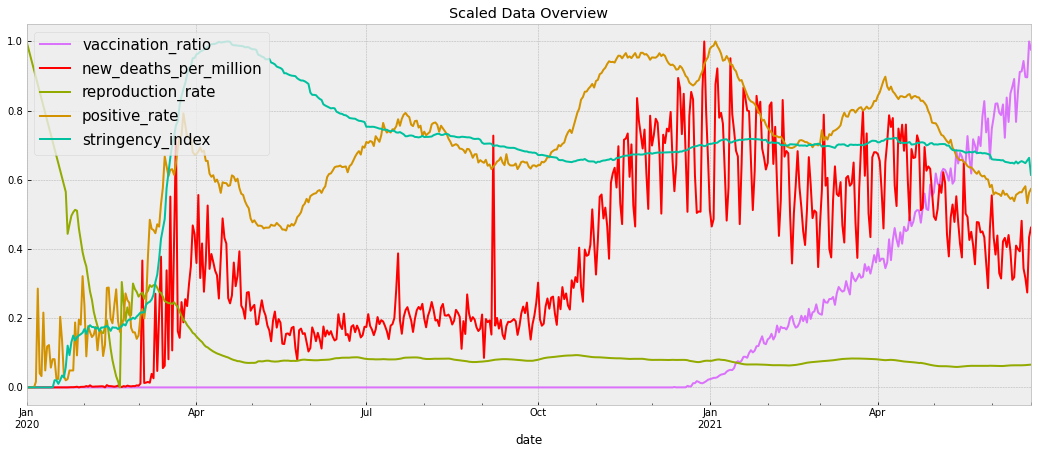

In [23]:
color_pal = ["#DB72FB", "red", "#93AA00", "#D39200", "#00C19F", "#00B9E3", "#619CFF", "#F8766D"]
#color_pal = ['green','red','#D39200','blue','brown']
cols = list(scaled_df.columns)
scaled_df[cols].plot( figsize=(18,7), color=color_pal, title='Scaled Data Overview')
plt.legend(loc='upper left',prop={'size': 15})
plt.show()

- The visual appeal of our data distribution shows that the new deaths per million is on a decline and we can make out a correlation between the stringency index and the new deaths per million.

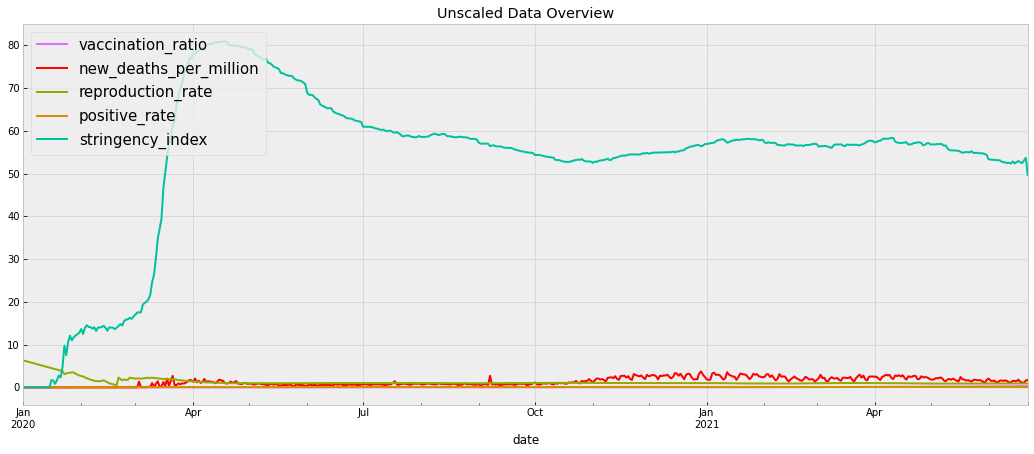

In [24]:
cols = list(mean_owid_df.columns)
mean_owid_df[cols].plot( figsize=(18,7), color=color_pal, title='Unscaled Data Overview')
plt.legend(loc='upper left',prop={'size': 15})
plt.show()

### Observing correlations in our dataset



In [63]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();

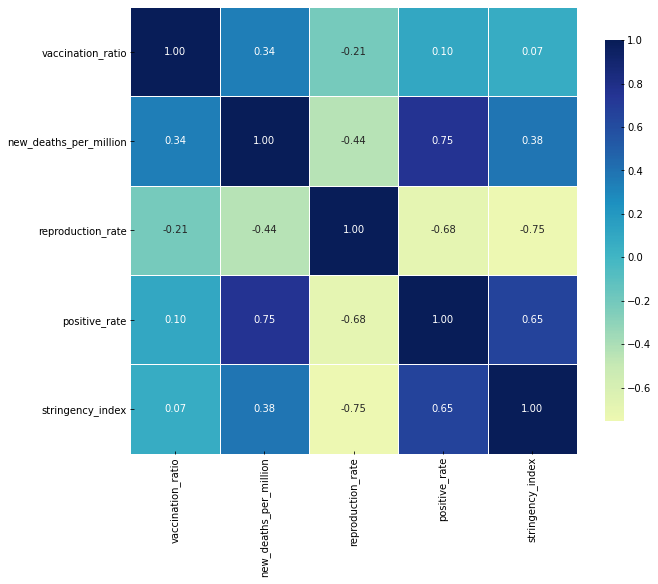

In [65]:
correlation_heatmap(mean_owid_df)

- We see a strong positive correlation between the positive_rate and the new_deaths_per_milliion = 0.75
- We see a strong negative correlation between the reproduction_rate and the stringency_index = -0.75
- From the above two observations, we can also see that there is a strong positive correlation between stringency_index and positive_rate = 0.65

## Training our XGBoost model

From the above plots we can see that a good train set can be from Jan2020 until ~01 Mar 2021. Keeping this in mind we can have the validation set from 01Mar2021 until Jun2021

##### Training unscaled data

[0]	validation_0-rmse:0.84692	validation_1-rmse:1.11193
[1]	validation_0-rmse:0.63627	validation_1-rmse:0.84160
[2]	validation_0-rmse:0.49419	validation_1-rmse:0.69188
[3]	validation_0-rmse:0.39524	validation_1-rmse:0.56151
[4]	validation_0-rmse:0.32585	validation_1-rmse:0.49251
[5]	validation_0-rmse:0.27033	validation_1-rmse:0.45310
[6]	validation_0-rmse:0.23414	validation_1-rmse:0.43838
[7]	validation_0-rmse:0.20427	validation_1-rmse:0.44044
[8]	validation_0-rmse:0.18790	validation_1-rmse:0.43947
[9]	validation_0-rmse:0.16837	validation_1-rmse:0.42965
[10]	validation_0-rmse:0.15756	validation_1-rmse:0.42371
[11]	validation_0-rmse:0.14871	validation_1-rmse:0.41873
[12]	validation_0-rmse:0.13767	validation_1-rmse:0.41700
[13]	validation_0-rmse:0.13125	validation_1-rmse:0.41620
[14]	validation_0-rmse:0.12535	validation_1-rmse:0.42077
[15]	validation_0-rmse:0.12041	validation_1-rmse:0.42270
[16]	validation_0-rmse:0.11807	validation_1-rmse:0.42181
[17]	validation_0-rmse:0.11413	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

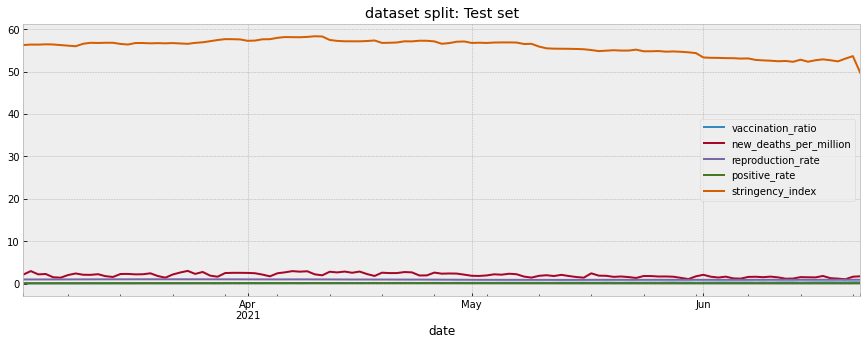

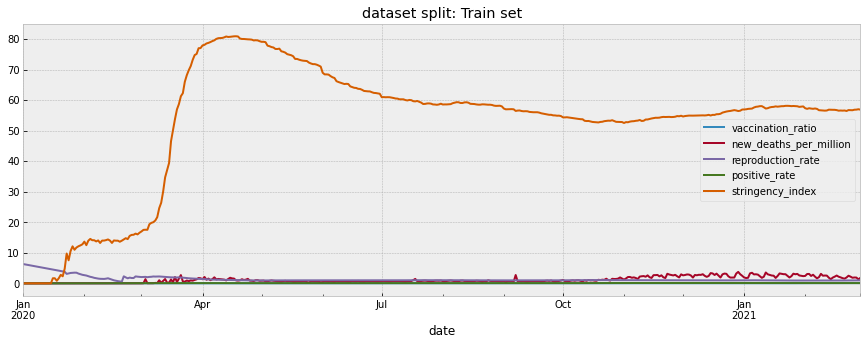

In [25]:
split_date = '01-Mar-2021'
unscaled_train = mean_owid_df.loc[mean_owid_df.index <= split_date].copy()
unscaled_test = mean_owid_df.loc[mean_owid_df.index > split_date].copy()
_ = unscaled_test \
.plot(figsize=(15,5), title='dataset split: Test set')
    
_ = unscaled_train \
.plot(figsize=(15,5), title='dataset split: Train set')

X_train_unscaled = unscaled_train.drop(['new_deaths_per_million'],axis=1)
y_train_unscaled = pd.DataFrame(unscaled_train['new_deaths_per_million'])

X_test_unscaled = unscaled_test.drop(['new_deaths_per_million'],axis=1)
y_test_unscaled = pd.DataFrame(unscaled_test['new_deaths_per_million'])

reg_unscaled = xgb.XGBRegressor(n_estimators=1000)
reg_unscaled.fit(X_train_unscaled, y_train_unscaled,
        eval_set=[(X_train_unscaled, y_train_unscaled), (X_test_unscaled, y_test_unscaled)],
        early_stopping_rounds=50,
       verbose=True)

##### Training scaled data

[0]	validation_0-rmse:0.22743	validation_1-rmse:0.11893
[1]	validation_0-rmse:0.16808	validation_1-rmse:0.11200
[2]	validation_0-rmse:0.12690	validation_1-rmse:0.10729
[3]	validation_0-rmse:0.09867	validation_1-rmse:0.10719
[4]	validation_0-rmse:0.08004	validation_1-rmse:0.11171
[5]	validation_0-rmse:0.06707	validation_1-rmse:0.11632
[6]	validation_0-rmse:0.05973	validation_1-rmse:0.11998
[7]	validation_0-rmse:0.05210	validation_1-rmse:0.11528
[8]	validation_0-rmse:0.04708	validation_1-rmse:0.11598
[9]	validation_0-rmse:0.04350	validation_1-rmse:0.11569
[10]	validation_0-rmse:0.03980	validation_1-rmse:0.11608
[11]	validation_0-rmse:0.03790	validation_1-rmse:0.11919
[12]	validation_0-rmse:0.03614	validation_1-rmse:0.11867
[13]	validation_0-rmse:0.03395	validation_1-rmse:0.11816
[14]	validation_0-rmse:0.03202	validation_1-rmse:0.11838
[15]	validation_0-rmse:0.03034	validation_1-rmse:0.11709
[16]	validation_0-rmse:0.02988	validation_1-rmse:0.11702
[17]	validation_0-rmse:0.02864	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

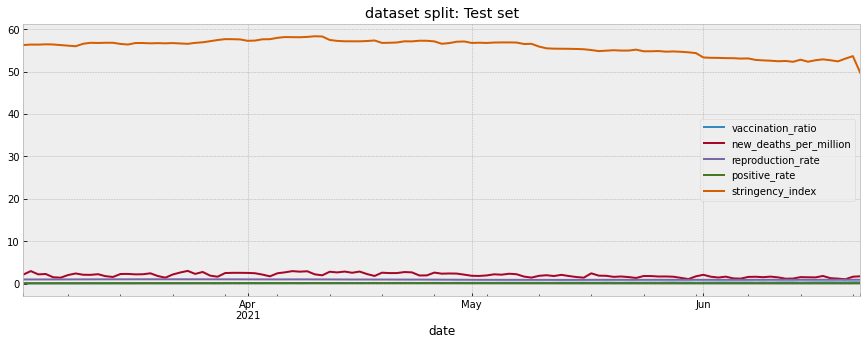

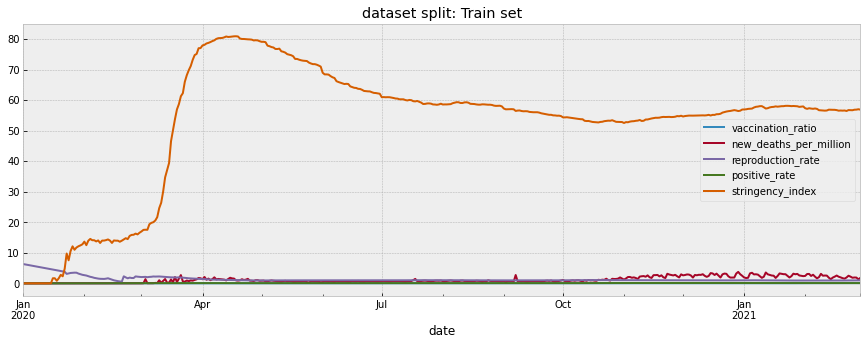

In [26]:
split_date = '01-Mar-2021'
scaled_train = scaled_df.loc[scaled_df.index <= split_date].copy()
scaled_test = scaled_df.loc[scaled_df.index > split_date].copy()
_ = unscaled_test \
.plot(figsize=(15,5), title='dataset split: Test set')
    
_ = unscaled_train \
.plot(figsize=(15,5), title='dataset split: Train set')

X_train_scaled = scaled_train.drop(['new_deaths_per_million'],axis=1)
y_train_scaled = pd.DataFrame(scaled_train['new_deaths_per_million'])

X_test_scaled = scaled_test.drop(['new_deaths_per_million'],axis=1)
y_test_scaled = pd.DataFrame(scaled_test['new_deaths_per_million'])

reg_scaled = xgb.XGBRegressor(n_estimators=1000)
reg_scaled.fit(X_train_scaled, y_train_scaled,
        eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
        early_stopping_rounds=50,
       verbose=True)

We see a significant decrease in rootmeansquared error on the validation set when we use the scaled data.

#### Feature importance

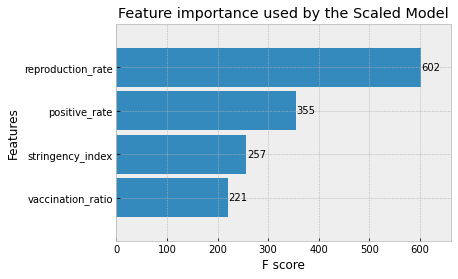

In [27]:
_ = plot_importance(reg_scaled, height=0.9, title='Feature importance used by the Scaled Model')

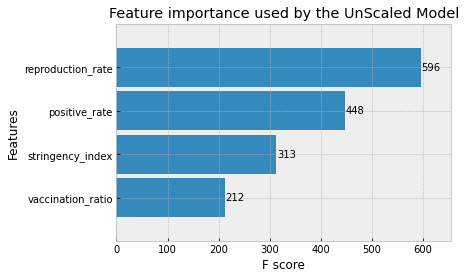

In [28]:
_ = plot_importance(reg_unscaled, height=0.9, title='Feature importance used by the UnScaled Model')

- We see that reproduction rate plays a significant role in determining the the number of new_deaths_per_million.
- This is something which was not seen directly from the data

##### Check model performance

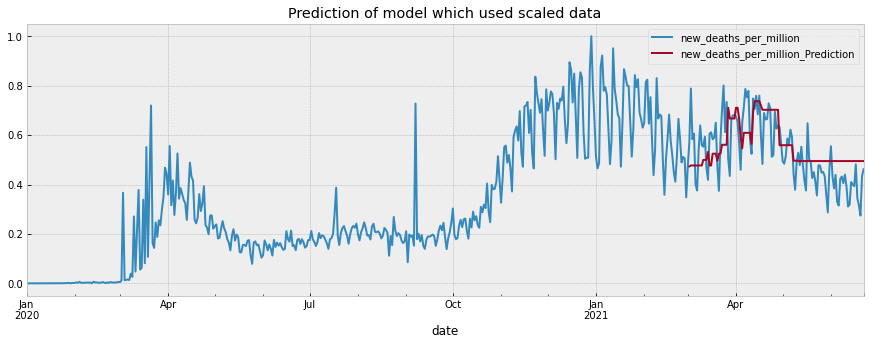

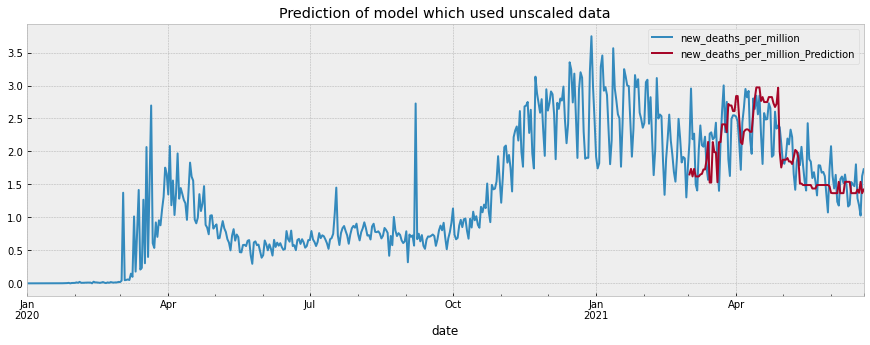

In [29]:
scaled_test['new_deaths_per_million_Prediction'] = reg_scaled.predict(X_test_scaled)

scaled_all = pd.concat([scaled_train,scaled_test], sort=False)
_ = scaled_all[['new_deaths_per_million','new_deaths_per_million_Prediction']].plot(figsize=(15, 5),title="Prediction of model which used scaled data")

unscaled_test['new_deaths_per_million_Prediction'] = reg_unscaled.predict(X_test_unscaled)

unscaled_all = pd.concat([unscaled_train,unscaled_test], sort=False)
_ = unscaled_all[['new_deaths_per_million','new_deaths_per_million_Prediction']].plot(figsize=(15, 5),title="Prediction of model which used unscaled data")

From the plots we can see that the model with unscaled data is on par with target value. Now let's look at some metrics which can explain why this happens

In [45]:
X_test_unscaled

,vaccination_ratio,reproduction_rate,positive_rate,stringency_index
date,,,,
2021-03-02,0.066734,0.976429,0.091132,56.300847
2021-03-03,0.080662,0.979396,0.087509,56.405537
2021-03-04,0.078073,0.980824,0.088840,56.389831
2021-03-05,0.077728,0.983901,0.087792,56.468362
2021-03-06,0.081168,0.986648,0.089717,56.426554
...,...,...,...,...
2021-06-18,0.299705,0.909511,0.070330,52.703925
2021-06-19,0.284928,0.911413,0.071255,52.440109
2021-06-20,0.284624,0.913696,0.065265,53.084186


In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
model_metrics = pd.DataFrame(columns=['underlying data used to train model','mean_squared_error','mean_absolute_error','mean_absolute_percentage_error'])

model_metrics = model_metrics.append({'underlying data used to train model':"Unscaled data",
                     'mean_squared_error' : mean_squared_error(y_true=unscaled_test['new_deaths_per_million'],y_pred=unscaled_test['new_deaths_per_million_Prediction']),
                     'mean_absolute_error': mean_absolute_error(y_true=unscaled_test['new_deaths_per_million'],y_pred=unscaled_test['new_deaths_per_million_Prediction']),
                     'mean_absolute_percentage_error': mean_absolute_percentage_error(y_true=unscaled_test['new_deaths_per_million'],y_pred=unscaled_test['new_deaths_per_million_Prediction'])},
                    ignore_index=True)

model_metrics = model_metrics.append({'underlying data used to train model':"Scaled data",
                     'mean_squared_error' : mean_squared_error(y_true=scaled_test['new_deaths_per_million'],y_pred=scaled_test['new_deaths_per_million_Prediction']),
                     'mean_absolute_error': mean_absolute_error(y_true=scaled_test['new_deaths_per_million'],y_pred=scaled_test['new_deaths_per_million_Prediction']),
                     'mean_absolute_percentage_error': mean_absolute_percentage_error(y_true=scaled_test['new_deaths_per_million'],y_pred=scaled_test['new_deaths_per_million_Prediction'])},
                    ignore_index=True)

In [32]:
model_metrics

,underlying data used to train model,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Unscaled data,0.173219,0.337743,17.424532
1,Scaled data,0.011491,0.086178,18.180601


We see that the mean absolute percentage error of both the models are almost the same, however, the mean squared and mean absolute error are significantly different. However, the mean_absolute_error is lower for the unscaled data, this explains why the model was on par with the later part of the test set

In [33]:
## Check for worst and best best predicted days
"""
scaled_test['error'] = scaled_test['new_deaths_per_million'] - scaled_test['new_deaths_per_million_Prediction']
scaled_test['abs_error'] = scaled_test['error'].apply(np.abs)
error_by_day = scaled_test.groupby(scaled_test.index).mean()[['new_deaths_per_million',
                                                              'new_deaths_per_million_Prediction','error','abs_error']]

error_by_day.sort_values('abs_error', ascending=False).index
"""

"\nscaled_test['error'] = scaled_test['new_deaths_per_million'] - scaled_test['new_deaths_per_million_Prediction']\nscaled_test['abs_error'] = scaled_test['error'].apply(np.abs)\nerror_by_day = scaled_test.groupby(scaled_test.index).mean()[['new_deaths_per_million',\n                                                              'new_deaths_per_million_Prediction','error','abs_error']]\n\nerror_by_day.sort_values('abs_error', ascending=False).index\n"

### Create the dataset for projection

##### Lets look at our dataset again

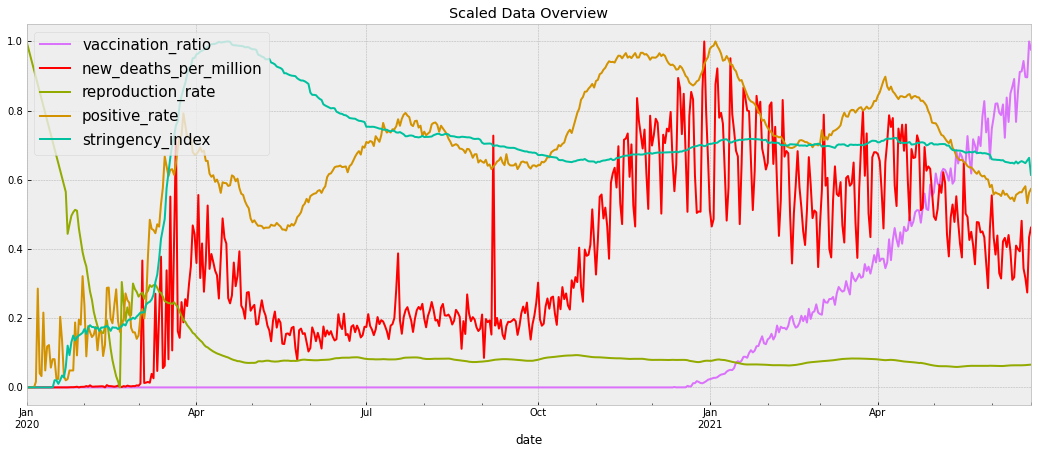

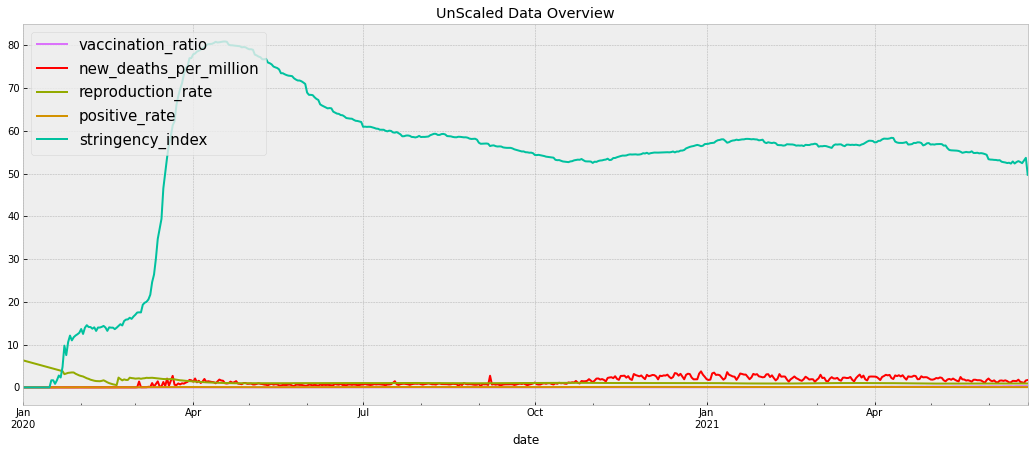

In [34]:

color_pal = ["#DB72FB", "red", "#93AA00", "#D39200", "#00C19F", "#00B9E3", "#619CFF", "#F8766D"]
#color_pal = ['green','red','#D39200','blue','brown']
cols = list(scaled_df.columns)
scaled_df[cols].plot( figsize=(18,7), color=color_pal, title='Scaled Data Overview')
plt.legend(loc='upper left',prop={'size': 15})
plt.show()

color_pal = ["#DB72FB", "red", "#93AA00", "#D39200", "#00C19F", "#00B9E3", "#619CFF", "#F8766D"]
#color_pal = ['green','red','#D39200','blue','brown']
cols = list(mean_owid_df.columns)
mean_owid_df[cols].plot( figsize=(18,7), color=color_pal, title='UnScaled Data Overview')
plt.legend(loc='upper left',prop={'size': 15})
plt.show()

#### To project: 
##### Dates: From 01-Apr-2021 until 01-Mar-2022
We project the data from 01-Apr-2021 to see how the projection data compares to the real data for the period from 01-Apr-2021 till 23-Jun-2021


<br>

- Vaccination ratio:
                     Approach- linear regression model.
                     Reason - This has to keep increasing because of all the vaccination drives happening in the world. So the max value for vaccination ratio is 1
<br>

- Stringency index: 
                    Approach - ARIMA / linear regression model
                    Reason - This can be projected using a regression model as we see that it keeps decreasing gradually over a period of time.
<br>

- positive rate: 
                    Approach - ARIMA / RNN model
                    Reason - This has got the second highest F-score on the XGboost model and having a good estimate at future point of time(synthetic data) will directly impact our prediction on that future date

<br>

- reproduction rate: 
                    Approach - ARIMA / RNN model
                    Reason - Since this has the highest F-score, our reproduction rate projections will directly impact our Prediction model. We can go ahead and use an ARIMA/RNN model to synthetically this


##### Synthetically projecting Vaccination ratio

- We know that vaccination has started roughly from Jan-2021. We use these dates to fit the linear regression model from Jan-2021 until 01-Apr-2021

In [35]:
def get_projection_vaccination_ratio(dataframe):
    
    mean_owid_df

### To - do
#### Visual Simulation
1) Use the model for a geographical plotting over a period of few months where the features are synthetically manipulated
- Vaccination_ratio: since vaccination ratio has to increase linearly, we can synthetically administer this
- reproduction_rate: As done before, we can use a linear regression model to project the reproduction rate [roughly from the time R_rate was ~~<=1.3]~~ or from the last 300 days
- positive_rate: This is one of the most important features which are 